In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

N_EPOCHES = 20

# Transfer learning 101

In this notebook we will be using the food 101 dataset: https://www.kaggle.com/kmader/food41
We will just load the data and resize it to 128x128 without looking too much into pre-processing or hyper parameter tuning given it is outside the scope of this session.

In [2]:
from get_dataset import DataSetGenerator
dataset_generator = DataSetGenerator(
    data_location=r"D:\data\food",
    batch_size=64,
    patch_dimension=128)
train_ds, val_ds = dataset_generator.get_datasets()

## Let's have a look at the data we are dealing with

We will vizualize 64 random images and its labels just to see what we are dealing with.
These image already have some data augmentation.

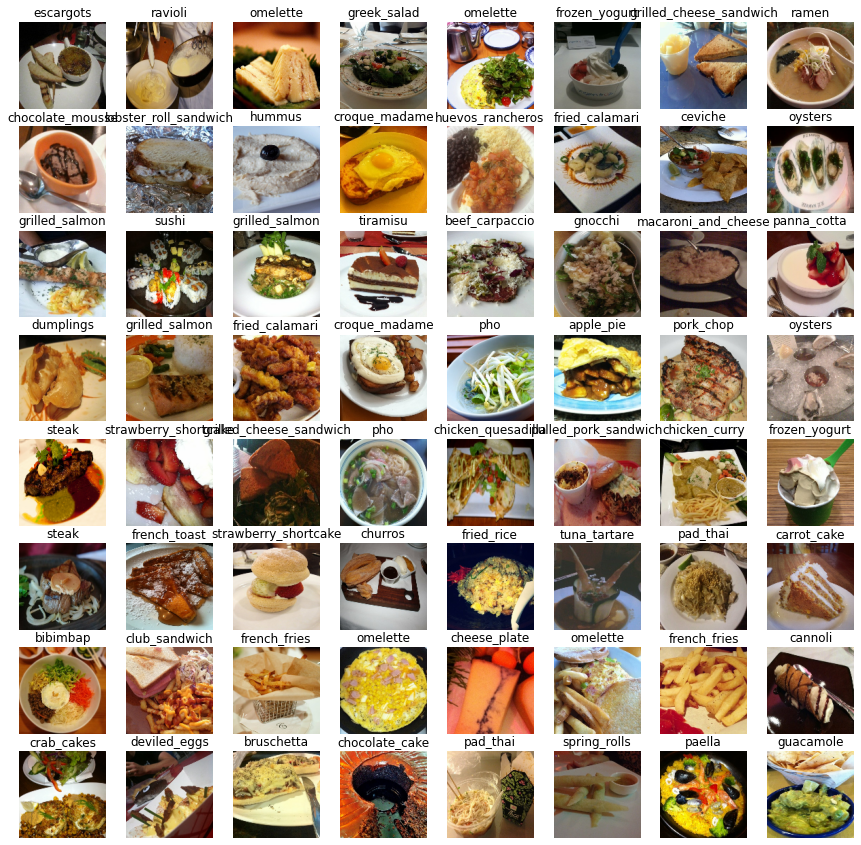

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(15,15))
for images, labels in train_ds.take(1):
  for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(dataset_generator.class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.show()

## Getting the model
We will download the [EfficientNet B0](https://arxiv.org/abs/1905.11946). This is a network optimized to have as little FLOPS for the maximum accuracy. The network can be downloaded with and without pre-trained weights. The pre-trained weights are trained on the [imageNet Challange](http://image-net.org/). These are nature image made with normale RGB camera's of everyday objects (not just food).

In this notebook we are gone to see what a difference it makes to have pre-trained weights VS random weights.

The model that is loaded is without a head because we only have 101 classes not thousands.

In [4]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Model

def create_model(weights="imagenet"):
    n_classes = len(dataset_generator.class_names)
    pre_trained_model = EfficientNetB0(include_top=False, weights=weights)

    input_layer = pre_trained_model.input
    max_pool = MaxPooling2D((4, 4))(pre_trained_model.output)

    dense1 = Dense(n_classes, activation="softmax")(max_pool)
    flat = Flatten()(dense1)

    model = Model(input_layer, flat)

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']
    )
    return model

## Training with random weights
We train the model with randomly generated weights as a baseline to compare our pre-trained network against.

In [5]:
model_no_pretrain = create_model(None)
history_no_pretrained = model_no_pretrain.fit(train_ds,
  validation_data=val_ds,
  epochs=N_EPOCHES
)

Epoch 1/20
1105/1105 [==============================] - 719s 650ms/step - loss: 4.8719 - accuracy: 0.0113 - val_loss: 6.4880 - val_accuracy: 0.0100
Epoch 2/20
1105/1105 [==============================] - 269s 244ms/step - loss: 4.7803 - accuracy: 0.0149 - val_loss: 7.8950 - val_accuracy: 0.0139
Epoch 3/20
1105/1105 [==============================] - 269s 244ms/step - loss: 4.7192 - accuracy: 0.0223 - val_loss: 4.7018 - val_accuracy: 0.0291
Epoch 4/20
1105/1105 [==============================] - 272s 246ms/step - loss: 4.7168 - accuracy: 0.0229 - val_loss: 4.6196 - val_accuracy: 0.0180
Epoch 5/20
1105/1105 [==============================] - 269s 243ms/step - loss: 4.6183 - accuracy: 0.0372 - val_loss: 4.5837 - val_accuracy: 0.0526
Epoch 6/20
1105/1105 [==============================] - 270s 244ms/step - loss: 4.4916 - accuracy: 0.0553 - val_loss: 4.4260 - val_accuracy: 0.0617
Epoch 7/20
1105/1105 [==============================] - 250s 226ms/step - loss: 4.3388 - accuracy: 0.0730 - val_

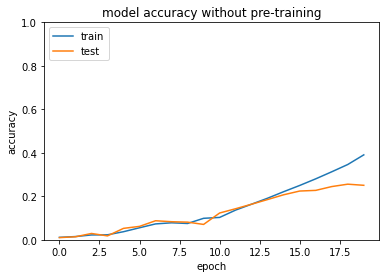

In [6]:
# summarize history for accuracy
plt.plot(history_no_pretrained.history['accuracy'])
plt.plot(history_no_pretrained.history['val_accuracy'])
plt.title('model accuracy without pre-training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

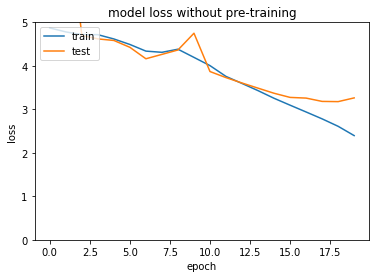

In [7]:
# summarize history for loss
plt.plot(history_no_pretrained.history['loss'])
plt.plot(history_no_pretrained.history['val_loss'])
plt.title('model loss without pre-training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,5])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## training with pre-trained weights
Next up we load a new model but this time with pretrained weights.
Everything else about the model is exactly the same.

In [9]:
model_with_pretrain = create_model("imagenet")
history_pretrained = model_with_pretrain.fit(train_ds,
  validation_data=val_ds,
  epochs=N_EPOCHES
)

Epoch 1/20
1105/1105 [==============================] - 258s 234ms/step - loss: 2.1702 - accuracy: 0.4758 - val_loss: 1.6153 - val_accuracy: 0.5893
Epoch 2/20
1105/1105 [==============================] - 245s 221ms/step - loss: 1.3409 - accuracy: 0.6467 - val_loss: 1.5491 - val_accuracy: 0.6152
Epoch 3/20
1105/1105 [==============================] - 251s 227ms/step - loss: 1.0788 - accuracy: 0.7051 - val_loss: 1.5022 - val_accuracy: 0.6298
Epoch 4/20
1105/1105 [==============================] - 754s 683ms/step - loss: 0.8906 - accuracy: 0.7518 - val_loss: 1.6548 - val_accuracy: 0.6095
Epoch 5/20
1105/1105 [==============================] - 240s 217ms/step - loss: 0.7528 - accuracy: 0.7861 - val_loss: 1.7202 - val_accuracy: 0.6153
Epoch 6/20
1105/1105 [==============================] - 246s 222ms/step - loss: 0.6333 - accuracy: 0.8139 - val_loss: 1.8284 - val_accuracy: 0.6192
Epoch 7/20
1105/1105 [==============================] - 254s 230ms/step - loss: 0.5533 - accuracy: 0.8356 - val_

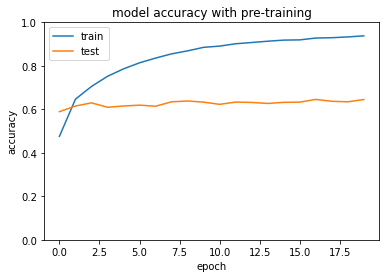

In [10]:
# summarize history for accuracy
plt.plot(history_pretrained.history['accuracy'])
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('model accuracy with pre-training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

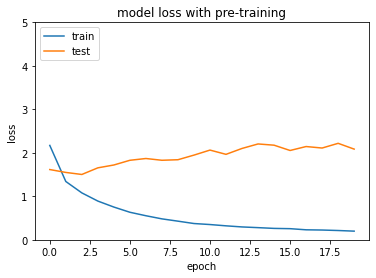

In [11]:
# summarize history for loss
plt.plot(history_pretrained.history['loss'])
plt.plot(history_pretrained.history['val_loss'])
plt.title('model loss with pre-training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,5])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Conclusion
We can see the pre-trained model being at a better accuracy and loss for both validation and training after 3 epoch compared to 50 epoch if we don't pre-train.

Be aware that the pre-trained model start overfitting way earlier.